In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 6)

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [31]:
mobile_sales = pd.read_excel('mobilesales.xlsx')
mobile_sales.head()

,DATE,Sales
0,2001-01-01,6519.0
1,2001-02-01,6654.0
2,2001-03-01,7332.0
3,2001-04-01,7332.0
4,2001-05-01,8240.0


In [32]:
mobile_sales.DATE.describe()

count                     217
unique                    217
top       2001-01-01 00:00:00
freq                        1
first     2001-01-01 00:00:00
last      2019-01-01 00:00:00
Name: DATE, dtype: object

In [33]:
# set the timeperiod as index 
mobile_sales.set_index('DATE', inplace=True)

<Axes: xlabel='DATE'>

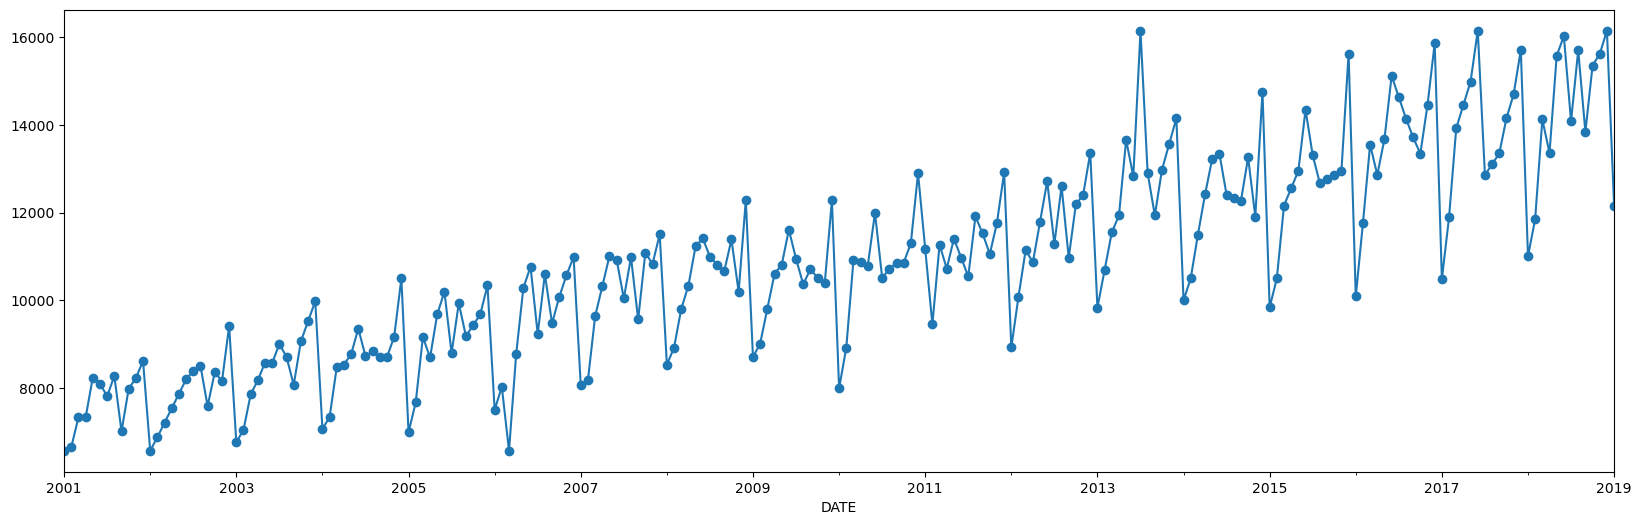

In [34]:
mobile_sales = pd.read_excel('mobilesales.xlsx')
mobile_sales.set_index('DATE', inplace=True)
mobile_sales.Sales = mobile_sales.Sales.interpolate()
mobile_sales.Sales = mobile_sales.Sales.clip(upper=mobile_sales.Sales.quantile(0.99), lower=mobile_sales.Sales.quantile(0.01))
mobile_sales.Sales.plot(style='-o')

In [35]:
import statsmodels.api as sm

model = sm.tsa.seasonal_decompose(mobile_sales.Sales, model='multiplicative')

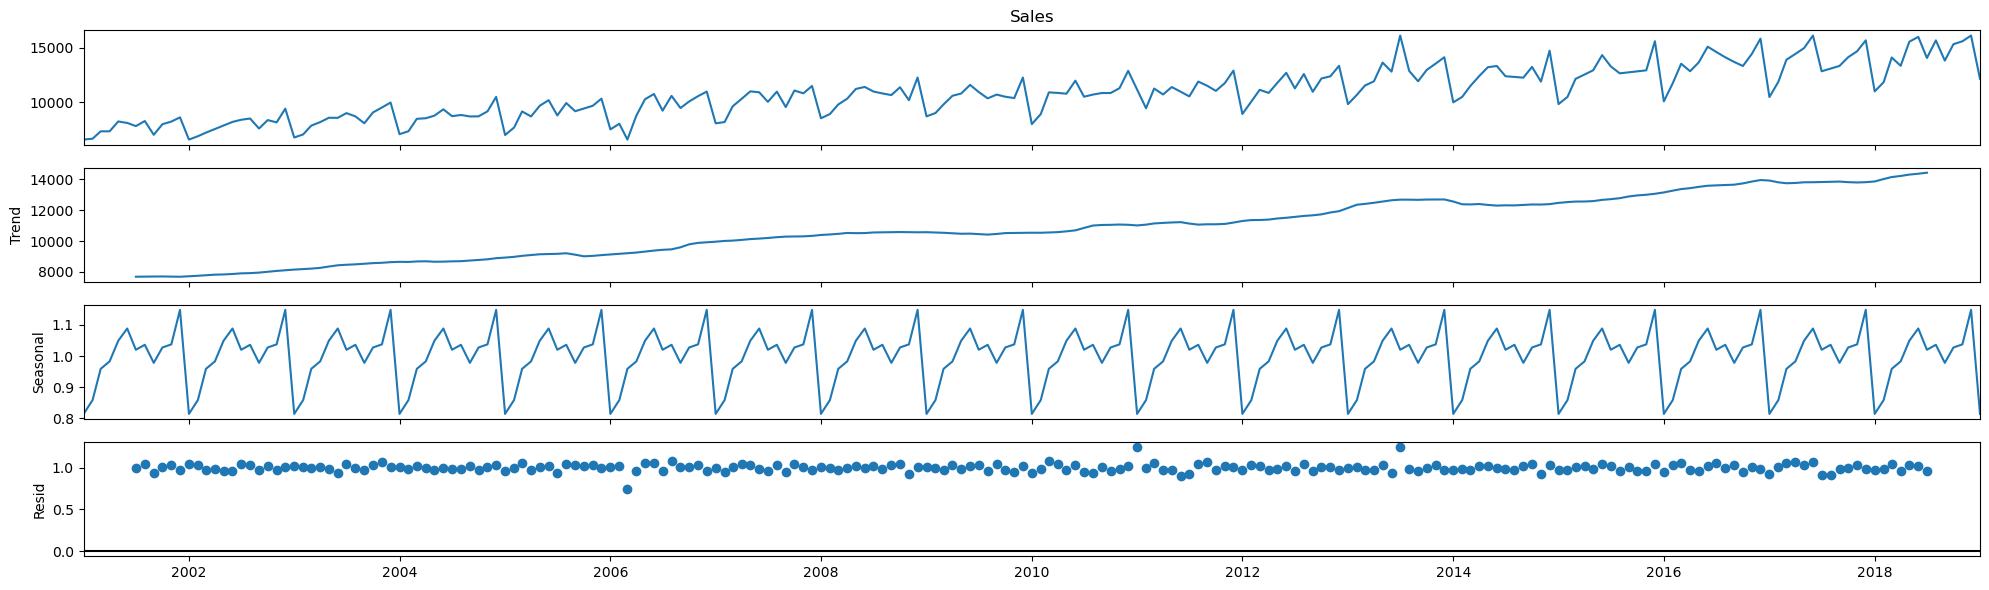

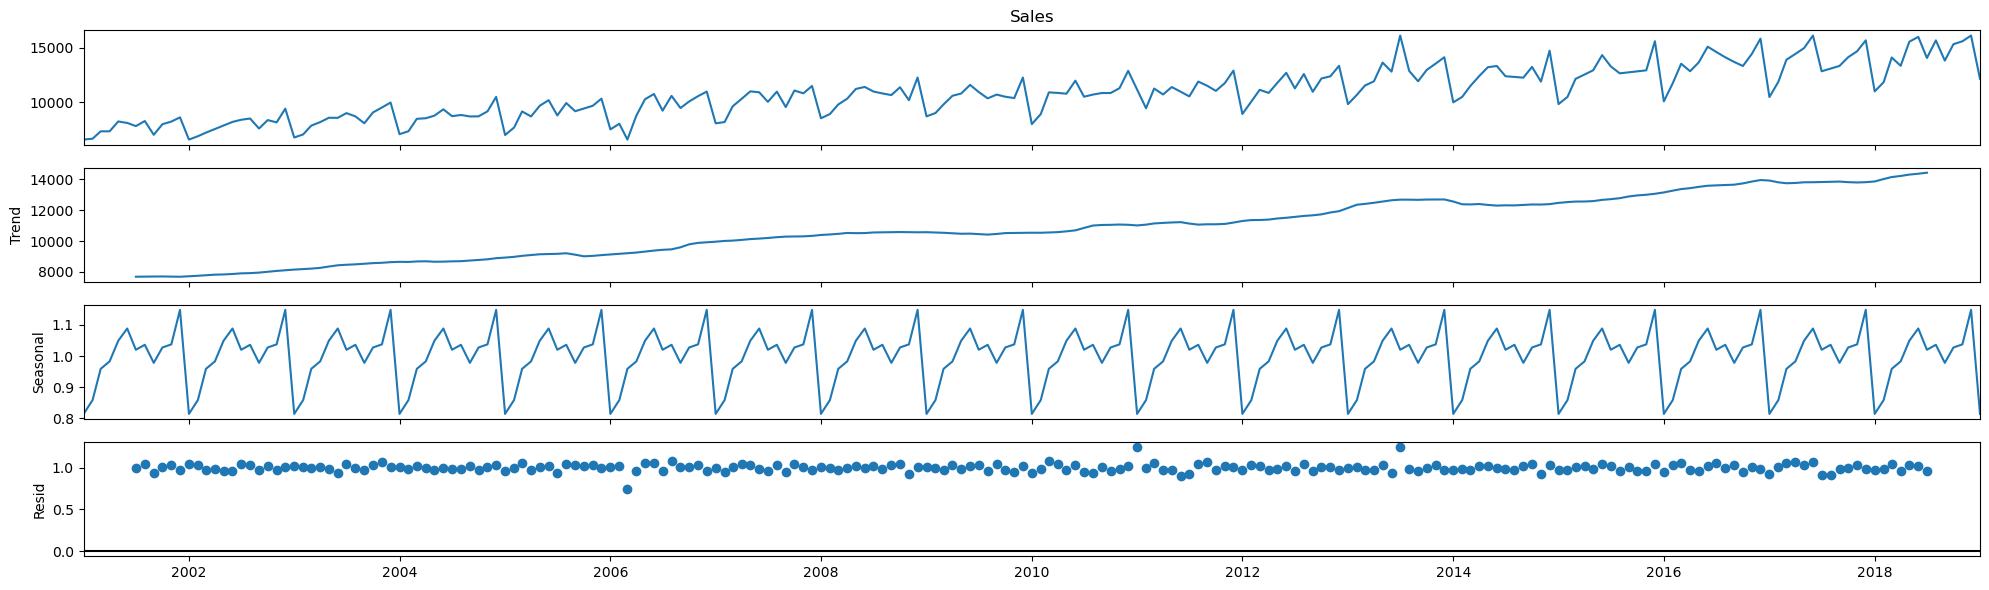

In [36]:
model.plot()

**What's trend?<br>**
Trend is found by taking the moving avg of the time series using the centred approach with window size 12 if is it monthly data. 

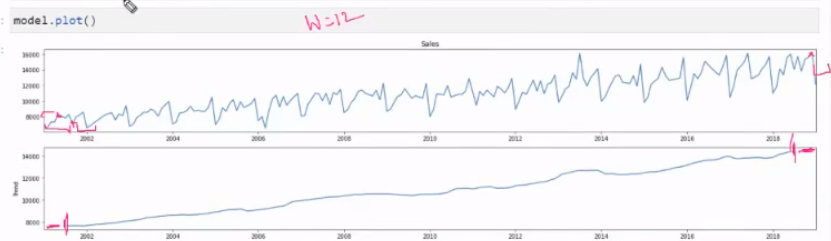

The first 6 and the last 6 values are missing in Trend. That's because window size 12 in centered approach require each point to have 6 points before it and 6 points after it. First and last 6 points don't satisfy that condition.

In [37]:
model.trend[:7]

DATE
2001-01-01            NaN
2001-02-01            NaN
2001-03-01            NaN
2001-04-01            NaN
2001-05-01            NaN
2001-06-01            NaN
2001-07-01    7681.113333
Name: trend, dtype: float64

##### Manually computing the trend to compare them

In [38]:
model = sm.tsa.seasonal_decompose(mobile_sales.Sales, model='additive')

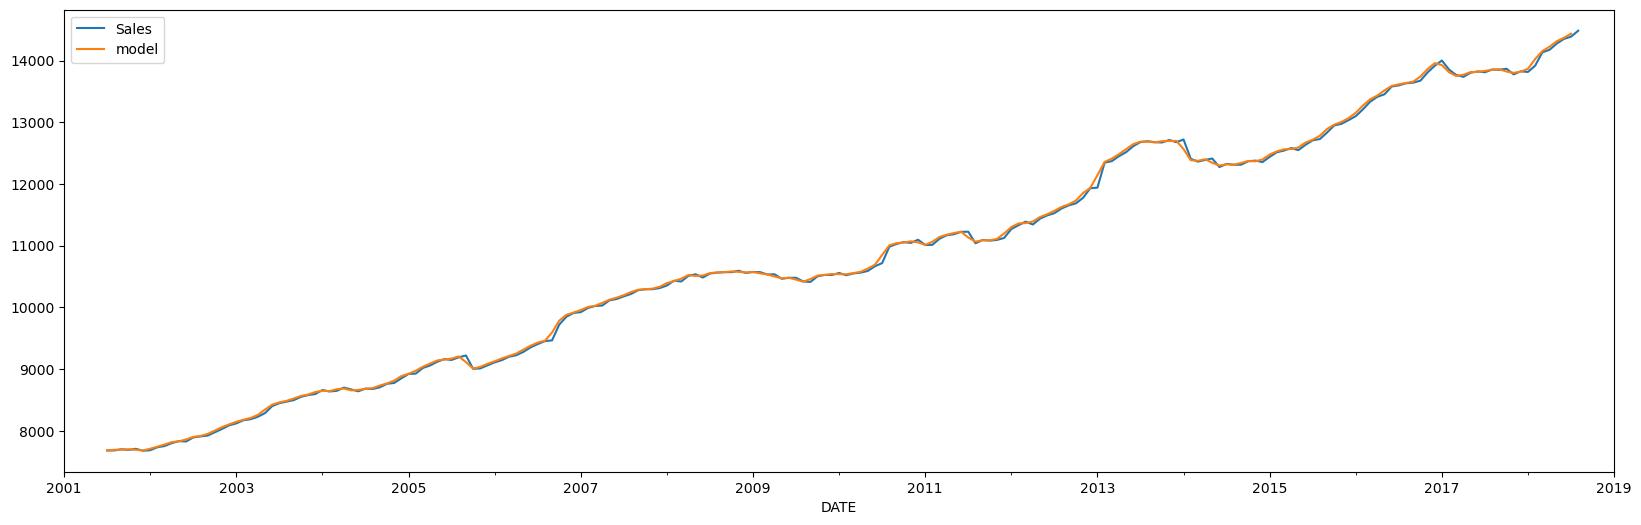

In [39]:
trend = mobile_sales.rolling(12, center=True).mean()
trend.plot(label = "ma")
model.trend.plot(label = "model")
plt.legend()

Ideally, they should both be the same. But, there's a very slight difference between these two.

##### De-trended time series:

<Axes: xlabel='DATE'>

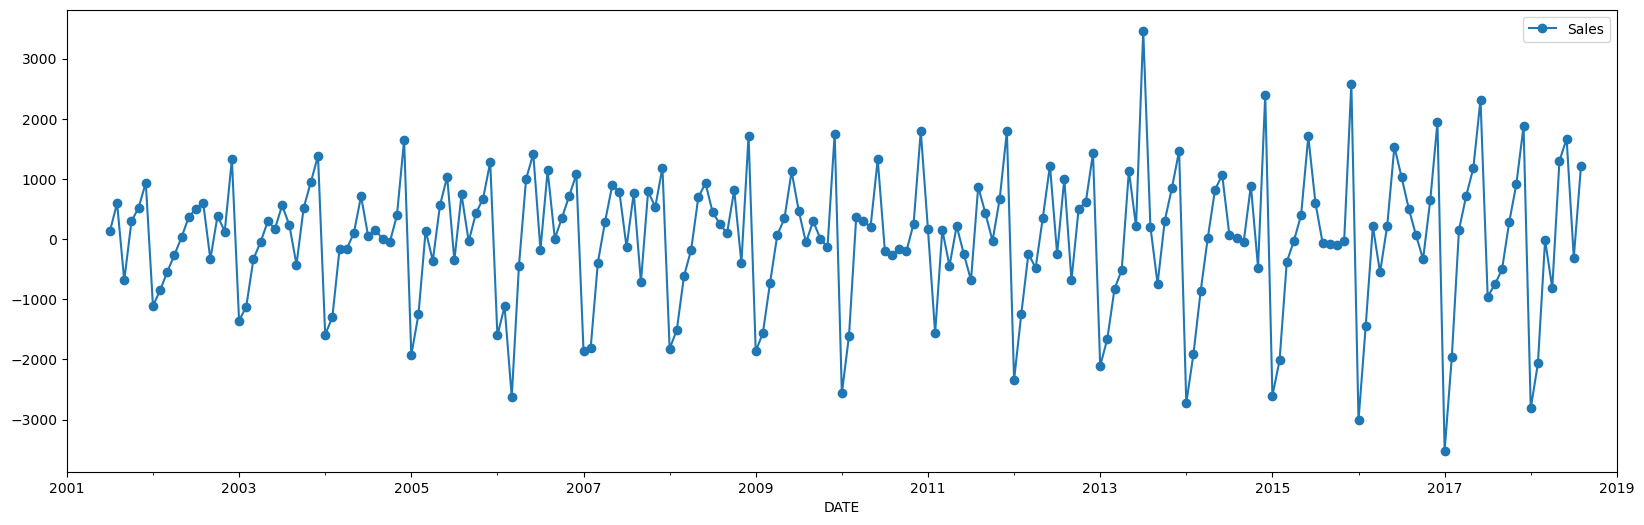

In [40]:
# de-trended time series
de_trend = mobile_sales - trend
de_trend.plot(style = "o-")

Our original time series was starting from 6000 and going up to 16000. But, this de-trended time series since we took the trend out is coming out to be between +ve, -ve, +ve values.

##### Seasonality for each month:

In [41]:
de_trend[:9]

,Sales
DATE,
2001-01-01,NaN
2001-02-01,NaN
2001-03-01,NaN
2001-04-01,NaN
2001-05-01,NaN
2001-06-01,NaN
2001-07-01,131.886667
2001-08-01,597.886667
2001-09-01,-686.113333


In [42]:
de_trend.reset_index()[:7]

,DATE,Sales
0,2001-01-01,NaN
1,2001-02-01,NaN
2,2001-03-01,NaN
3,2001-04-01,NaN
4,2001-05-01,NaN
5,2001-06-01,NaN
6,2001-07-01,131.886667


<Axes: xlabel='DATE'>

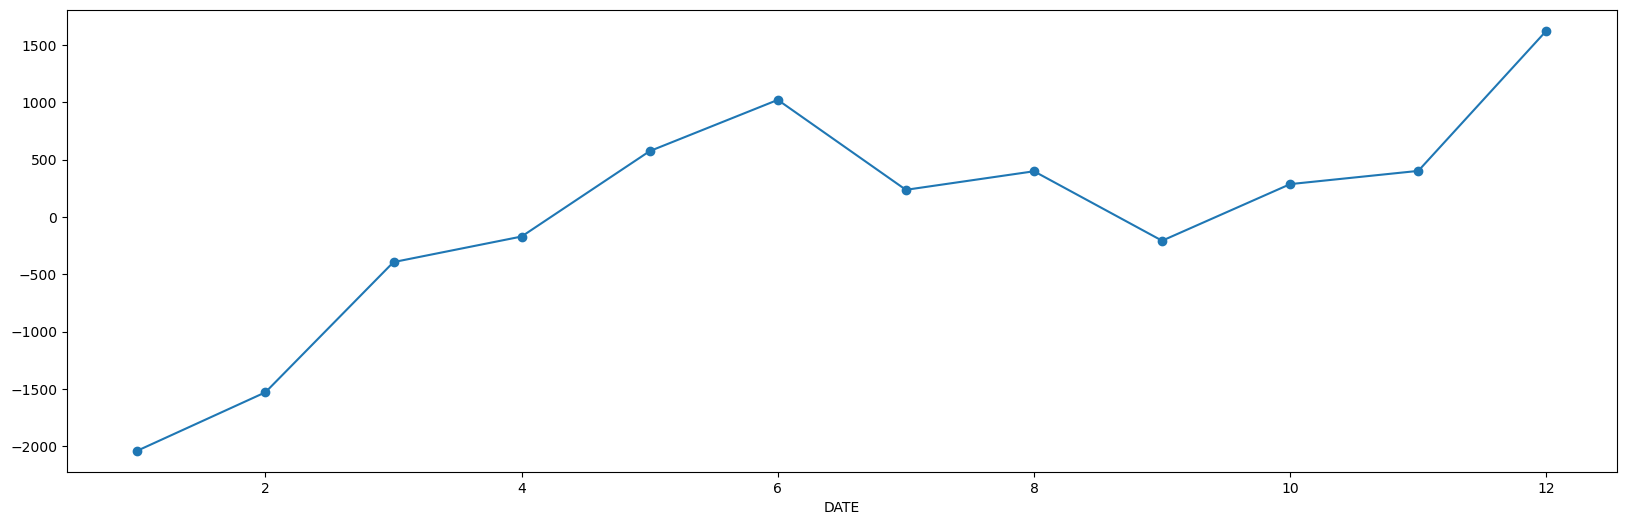

In [43]:
dtf = de_trend.reset_index()
dtf.groupby(dtf.DATE.dt.month)['Sales'].mean().plot(style='-o')

1 ie. Jan, it is -2000, for 6 ie. June, it is +1000, for 12, it is roughly 1500.

In [44]:
dtf.groupby(dtf.DATE.dt.month)['Sales'].mean()     # 1 is Jan here and so on..

DATE
1    -2037.722353
2    -1528.346471
3     -392.982157
4     -169.983725
5      574.761373
6     1021.613137
7      237.311296
8      399.059444
9     -206.498431
10     287.055490
11     402.408431
12    1624.624118
Name: Sales, dtype: float64

##### Understanding the relation between trend and seasonality:

June 2001 is roughly around 8000:

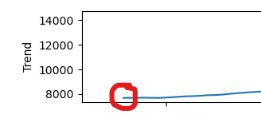

But, according to seasonality, June will have roughly 1000 more:

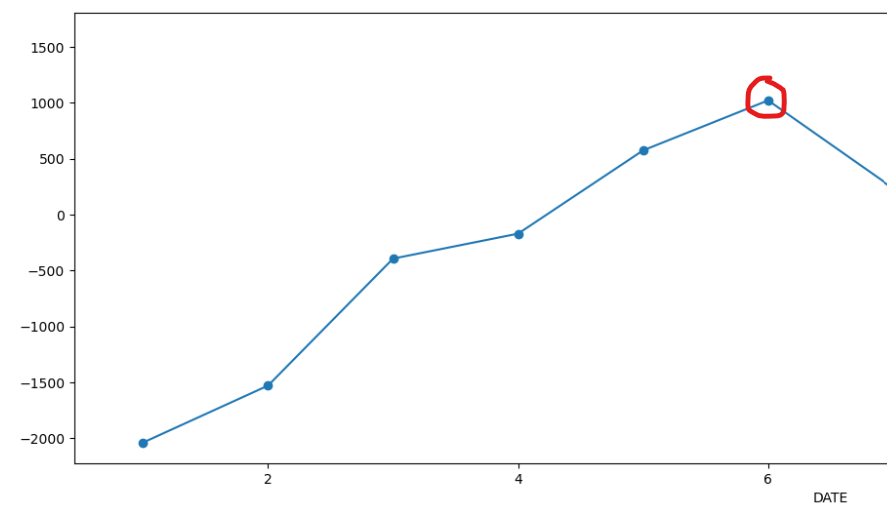

##### Seasonality for the entire time period:

In [45]:
dtf.groupby(dtf.DATE.dt.month)['Sales'].transform('mean')

0     -2037.722353
1     -1528.346471
2      -392.982157
3      -169.983725
4       574.761373
          ...     
212    -206.498431
213     287.055490
214     402.408431
215    1624.624118
216   -2037.722353
Name: Sales, Length: 217, dtype: float64

In [46]:
dtf

,DATE,Sales
0,2001-01-01,NaN
1,2001-02-01,NaN
2,2001-03-01,NaN
3,2001-04-01,NaN
4,2001-05-01,NaN
...,...,...
212,2018-09-01,NaN
213,2018-10-01,NaN
214,2018-11-01,NaN
215,2018-12-01,NaN


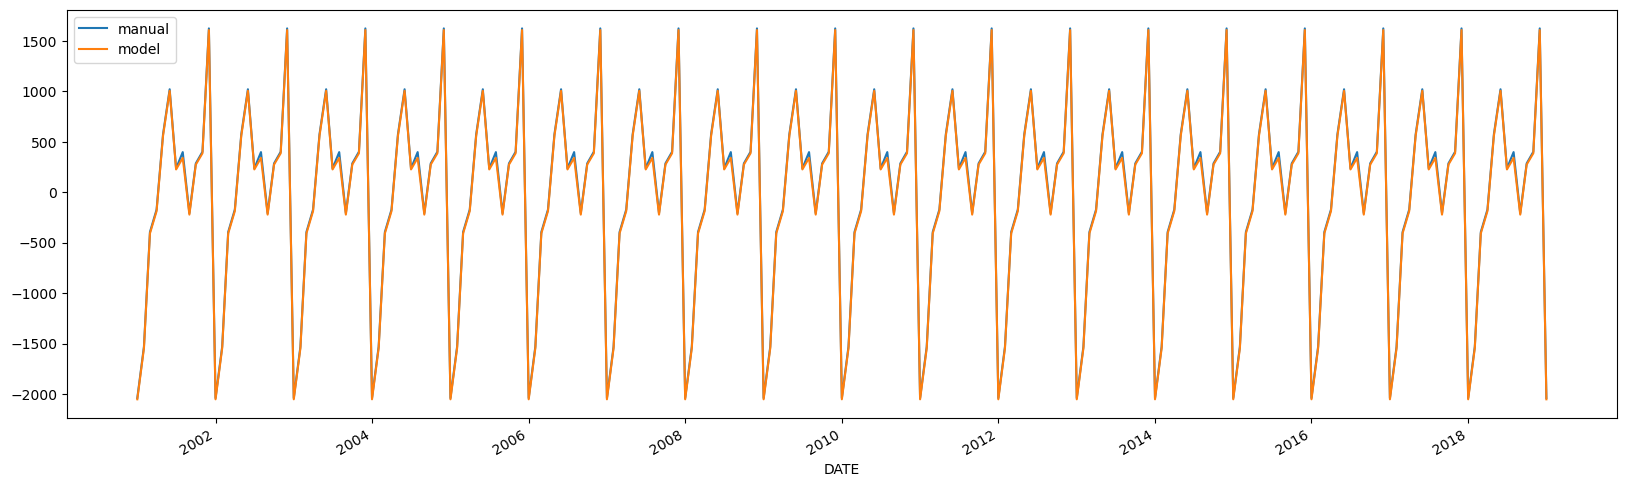

In [47]:
plt.plot(dtf.DATE, dtf.groupby(dtf.DATE.dt.month)['Sales'].transform('mean'), label = 'manual')
model.seasonal.plot(label = 'model')
plt.legend()
# transform: output will have the same length and index as the original DataFrame, 
# and each row will show the mean sales value for the respective month of that row.

de-trended time series is seasonality + randomness. But, this is seasonality only, no randomness.

You can see, the seasonal values are exactly same for each year because for Jan, we'll have one value, for Feb also one value. That's why every year is like a mirror replica of each other.

**error**<br>
If we club this seasonal and trend, it should ideally give me the actual time series. But, it won't. <br>Let's say as per seasonality, May was supposed to be 45 but it was the hottest year and it gave 46 degrees temperature. So slight error would be there and that's the residual.

**Constant vs non-constant variance:**<br>
Both peaks and lows are having similar magnitude.

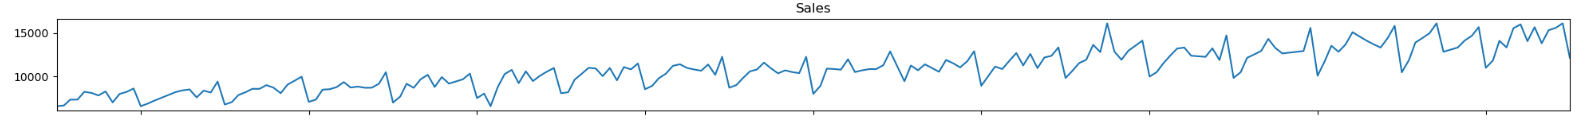

The peaks below keep growing each year. Hence, non-constant variance. For this type of time series, multiplicative decomposition is used.

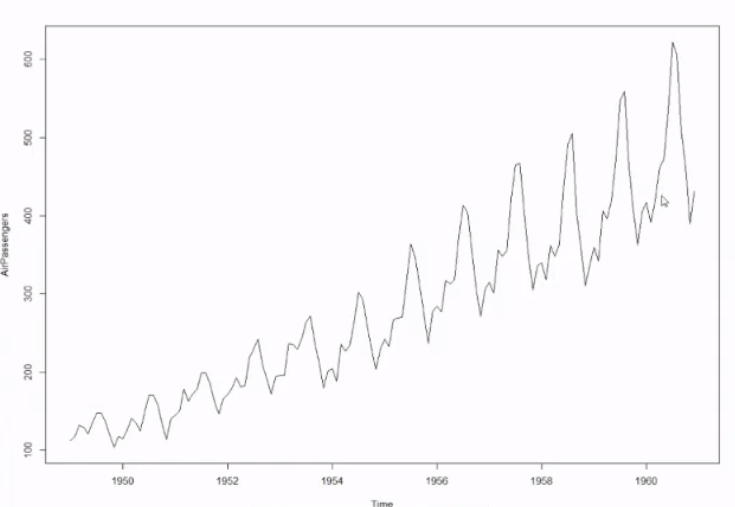

## Simple forecasting methods in action , train vs test performance 

We do time based split, not random split in time series.

In [48]:
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae, 
    mean_absolute_percentage_error as mape
)

# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3)) 
    print('MAPE:', round(mape(actual, predicted)*100, 3))

In [49]:
train_x = mobile_sales.loc[mobile_sales.index < mobile_sales.index[-12]].copy()
test_x = mobile_sales.loc[mobile_sales.index >= mobile_sales.index[-12]].copy()

test_x

,Sales
DATE,
2018-02-01,11852.00
2018-03-01,14123.00
2018-04-01,13360.00
2018-05-01,15576.00
2018-06-01,16021.00
2018-07-01,14080.00
2018-08-01,15697.00
2018-09-01,13838.00
2018-10-01,15351.00


MAE : 3479.79
RMSE : 3757.483
MAPE: 23.24


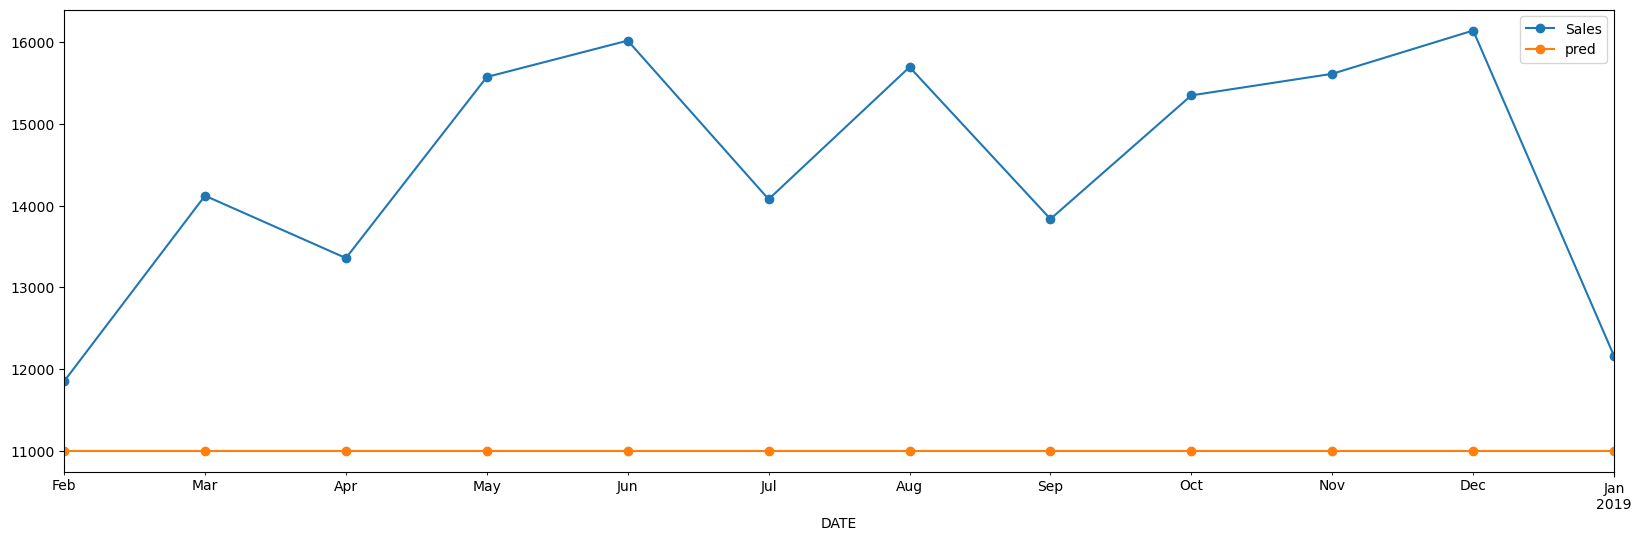

In [50]:
# Padding
test_x['pred'] = train_x['Sales'][-1]    # take the last/latest data point from train data(trend).
# that'll be our forecast for all the future time periods.
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])       # original, predicted

Since, the value of Jan 2018 may have been 11000, that's the value it is giving for all the future months. It is very off compared to the original values.<br>
MAPE: 23.24% error which is too much.

In [51]:
test_x

,Sales,pred
DATE,,
2018-02-01,11852.00,11005.0
2018-03-01,14123.00,11005.0
2018-04-01,13360.00,11005.0
2018-05-01,15576.00,11005.0
2018-06-01,16021.00,11005.0
2018-07-01,14080.00,11005.0
2018-08-01,15697.00,11005.0
2018-09-01,13838.00,11005.0
2018-10-01,15351.00,11005.0


MAE : 3832.336
RMSE : 4086.14
MAPE: 25.699


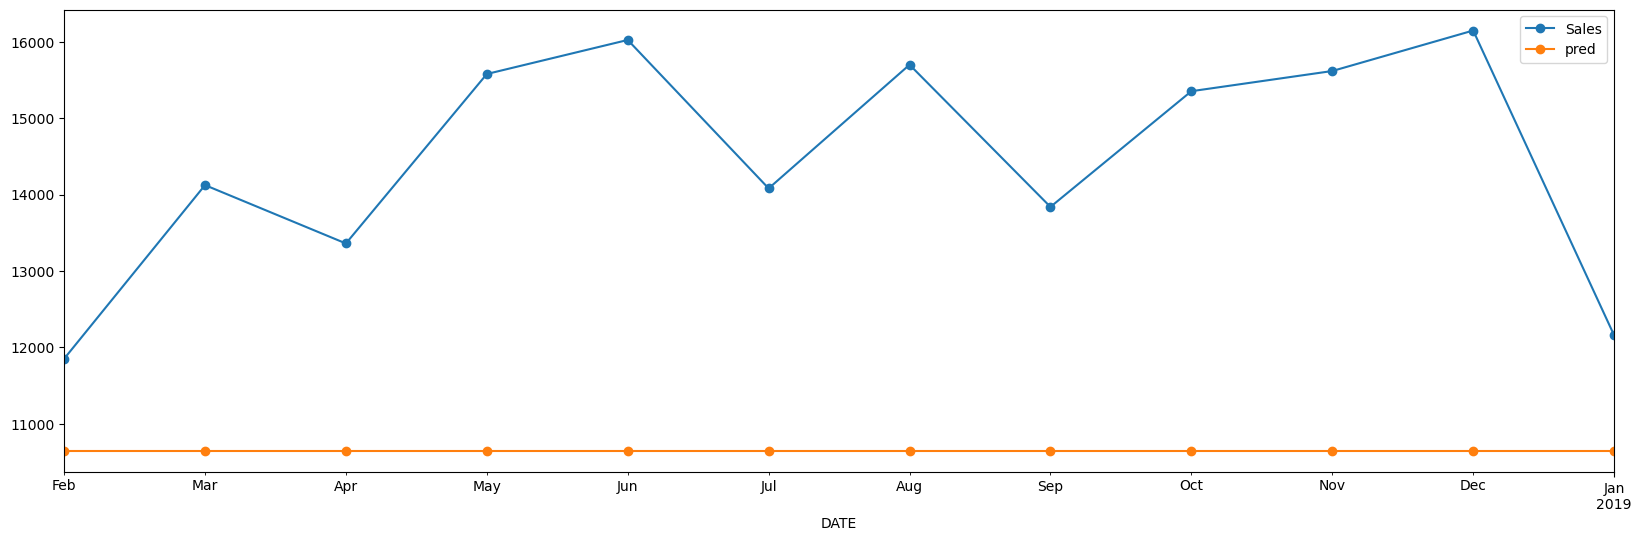

In [52]:
# Global mean or entire train data mean 
test_x['pred'] = train_x['Sales'].mean()

test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

- Look at the MAPE. It's even worse than padding. 
- Since time series had values starting from 6000 to 16000, that's why it has taken mean of approx 10,000

Which one of the following methods will work best here?<br>
- Pad
- Drift
- moving averages (with some window)
- Seasonal Naive Forecast (Last year March, what was the value.)

In [53]:
test_x.index

DatetimeIndex(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
              dtype='datetime64[ns]', name='DATE', freq=None)

MAE : 839.08
RMSE : 1075.542
MAPE: 5.765


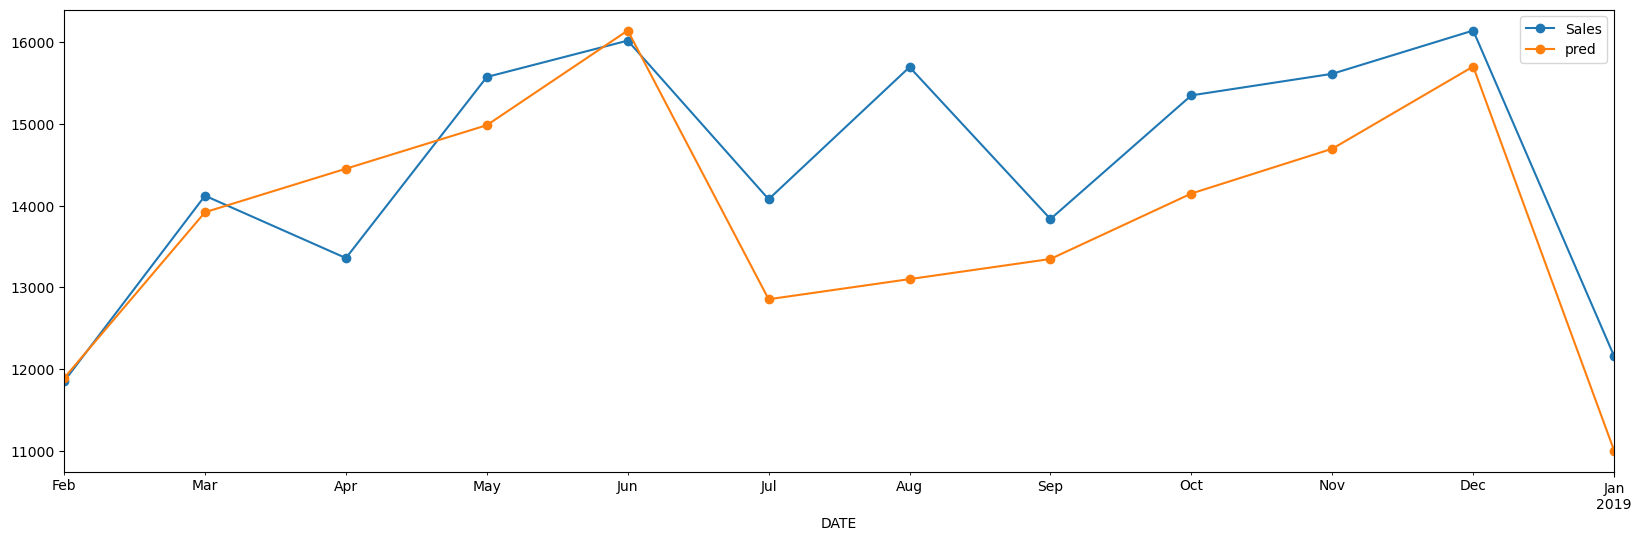

In [54]:
# Seasonal naive method 

for i in test_x.index:
    test_x.loc[i]['pred'] = train_x.loc[i - pd.DateOffset(years=1)].Sales    # one year prior to the current date

test_x.plot(style='-o')

performance(test_x['Sales'], test_x['pred'])

- It is doing a much better job.
- Error decreased to 5.7 percentage.

MAE : 3360.892
RMSE : 3640.673
MAPE: 22.424


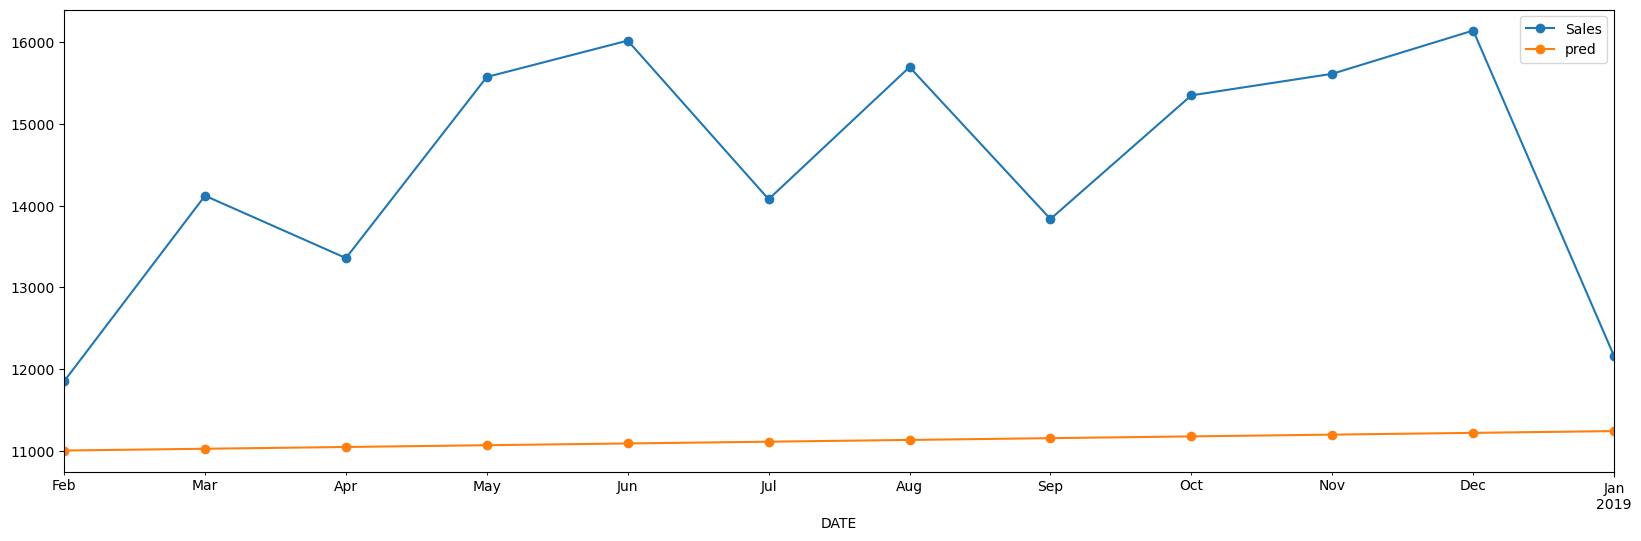

In [55]:
## Drift method 

y_t = train_x['Sales'][-1]
y_0 = train_x['Sales'][0]

m = (y_t - y_0) / len(train_x['Sales'])         # slope: (last observation - earliest obs) / total_length
h = np.linspace(0,len(test_x)-1, len(test_x))   # instance: 1,2,3

test_x['pred'] = y_t + m * h

test_x.plot(style='-o')

performance(test_x['Sales'], test_x['pred'])

- Since the slope was negligible, it is giving 11000 which is as good as padding.
- Error is also high

## Simple exponential smoothing 

In [56]:
model = sm.tsa.SimpleExpSmoothing(mobile_sales.Sales)
_ = model.fit(smoothing_level = 0.8) # This is the alpha here. It's a hyperparameter. There's no fixed value for it.
# We can run a loop on test data from .1 to .9 and whiever is the lowest value of mape will be the best value of alpha.
_.fittedvalues   # values that the time series model predicts for each observation in the training dataset.

DATE
2001-01-01     6573.360000
2001-02-01     6573.360000
2001-03-01     6637.872000
2001-04-01     7193.174400
2001-05-01     7304.234880
                  ...     
2018-09-01    15444.233816
2018-10-01    14159.246763
2018-11-01    15112.649353
2018-12-01    15514.529871
2019-01-01    16018.489974
Length: 217, dtype: float64

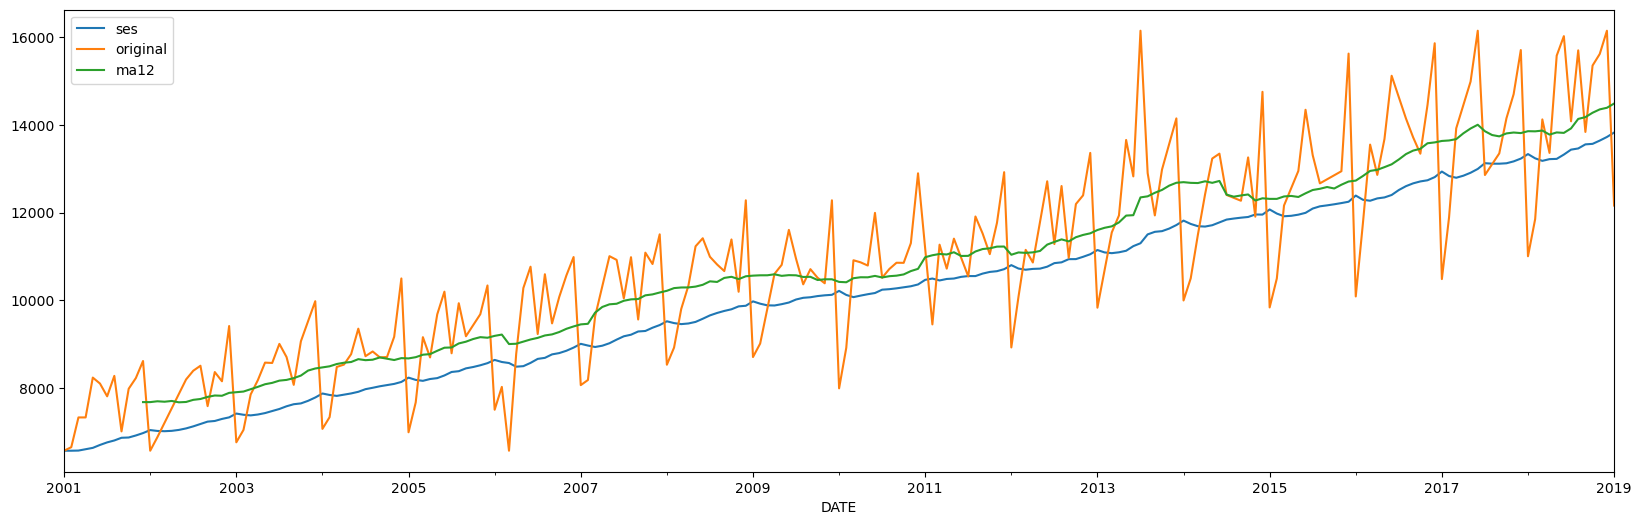

In [57]:
pred = pd.Series(sm.tsa.SimpleExpSmoothing(mobile_sales.Sales).fit(smoothing_level=1/(2*12)).fittedvalues)     # 1/(2*12) = 0.0416

pred.plot(label='ses')
mobile_sales.Sales.plot(label='original')
mobile_sales.Sales.rolling(12).mean().plot(label='ma12')
plt.legend()

- It seems like moving avg with window = 12 might be doing a bit better than simple exponential smoothing.
- The reason is maybe for this type of this data, recency is not that important and thus, ses is not giving great results. In fact, here maybe past few values avg works very well.

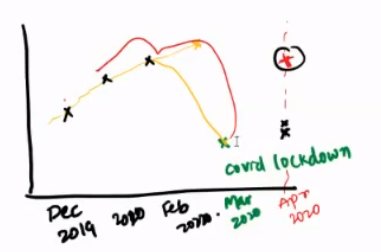

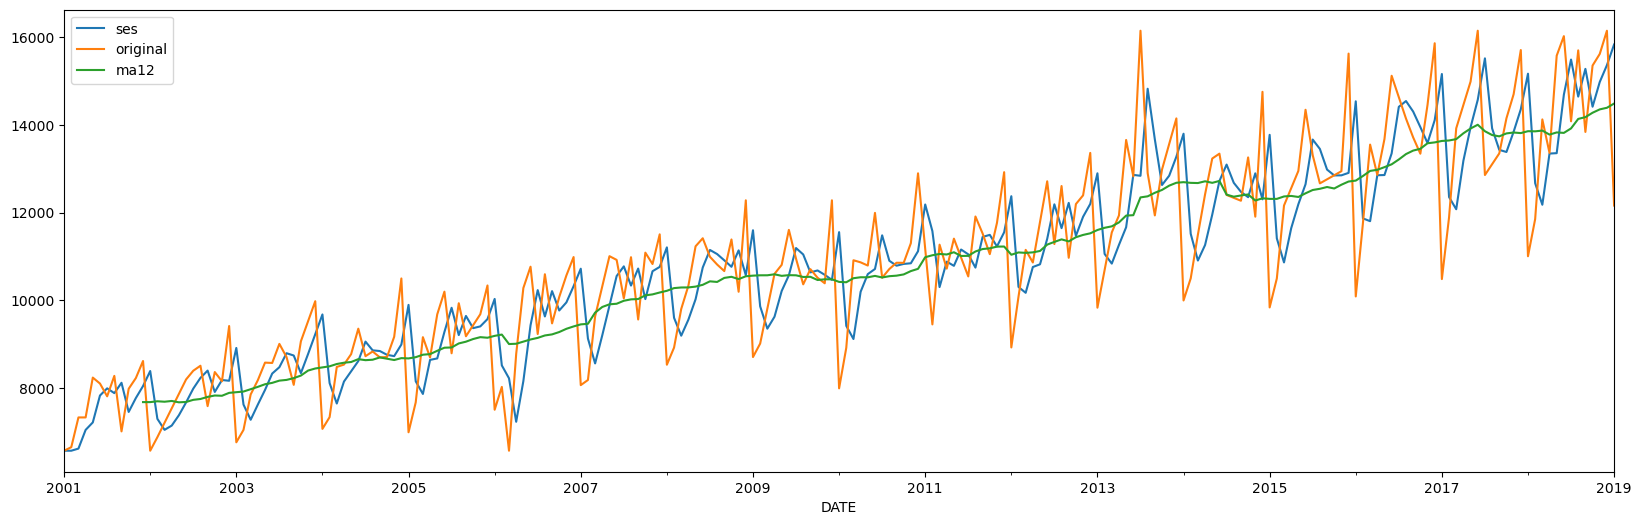

In [58]:
pred = pd.Series(sm.tsa.SimpleExpSmoothing(mobile_sales.Sales).fit(smoothing_level=0.6).fittedvalues)    

pred.plot(label='ses')
mobile_sales.Sales.plot(label='original')
mobile_sales.Sales.rolling(12).mean().plot(label='ma12')
plt.legend()

- It's giving good results after changing smoothing level to 0.6

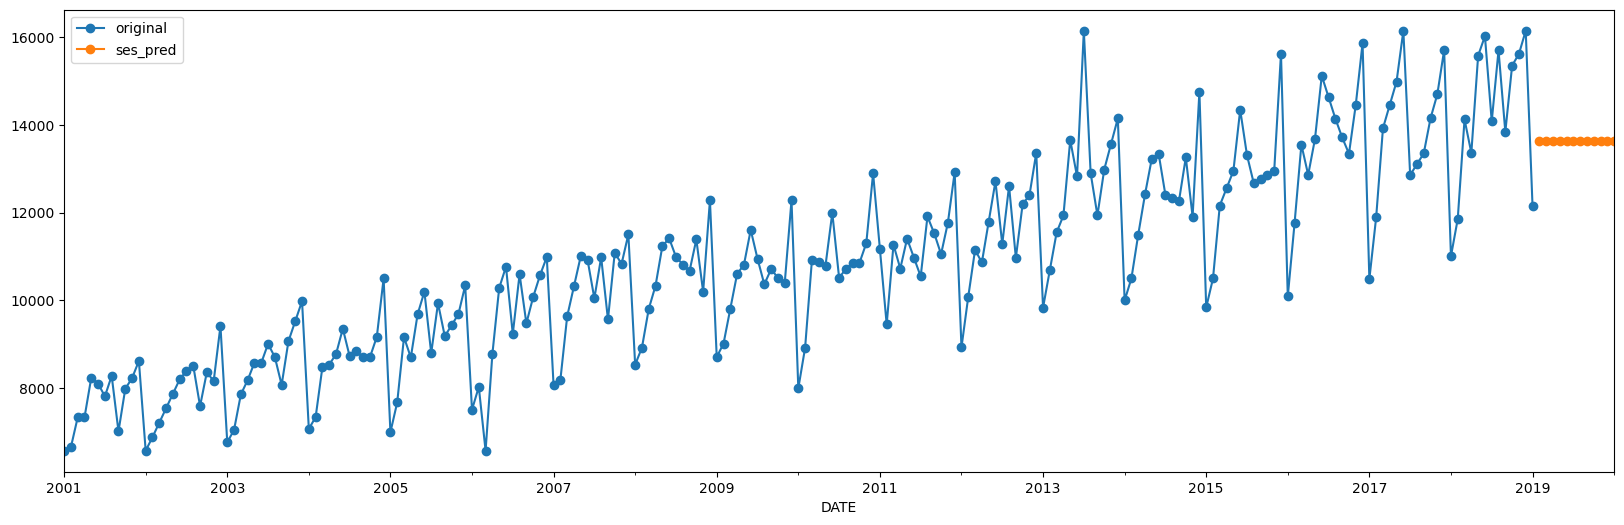

In [59]:
# how the forecast would look like
model = sm.tsa.SimpleExpSmoothing(mobile_sales.Sales).fit(smoothing_level=0.6)
pred = model.forecast(12) # forecast for the next 12 months

mobile_sales.Sales.plot(label='original', style='-o')
pred.plot(label='ses_pred', style='-o')
plt.legend()

- The prediction is very flat. Not much variation.
- Maybe the last 2 points are getting higher weightage and the points before them are getting negligible weightage.

In [60]:
pred # it actually generated the same values for the next 12 months.

2019-02-01    13628.165375
2019-03-01    13628.165375
2019-04-01    13628.165375
2019-05-01    13628.165375
2019-06-01    13628.165375
2019-07-01    13628.165375
2019-08-01    13628.165375
2019-09-01    13628.165375
2019-10-01    13628.165375
2019-11-01    13628.165375
2019-12-01    13628.165375
2020-01-01    13628.165375
Freq: MS, dtype: float64

In [61]:
test_x

,Sales,pred
DATE,,
2018-02-01,11852.00,11005.000000
2018-03-01,14123.00,11026.617756
2018-04-01,13360.00,11048.235512
2018-05-01,15576.00,11069.853268
2018-06-01,16021.00,11091.471024
2018-07-01,14080.00,11113.088780
2018-08-01,15697.00,11134.706537
2018-09-01,13838.00,11156.324293
2018-10-01,15351.00,11177.942049


In [62]:
mape(test_x.Sales,pred )*100

9.78751384570306

Going forward, we'll learn how we can use Trend and Seasonality to make our forecast better.

**If you have any questions, get in touch with me [here](https://linktr.ee/khushalkumar31)